# Correctly/Incorrectly Worn Face Mask Detection

## Setting up

In [1]:
import sys
sys.path
sys.executable

'/Users/nguyen_l5/opt/anaconda3/envs/myenv/bin/python'

In [30]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import random
import os
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import ConfigProto
import cv2

In [2]:
IMAGE_SIZE = (300, 300) # resizing to reduce number of parameters
IMG_DIR = '/Users/nguyen_l5/Downloads/data' #change the directory accordingly
BATCH_SIZE = 64
NUM_CLASSES = 5 # 5 classes within the accumulated dataset

## Create dataset

In [3]:
dataset = []
for fold in os.listdir(IMG_DIR):
    if fold == 'incorrect':
        for filename in os.listdir(f'{IMG_DIR}/{fold}'):
            dataset.append((f'{fold}/{filename}', filename[11:].split('.')[0]))
    elif fold == 'maskoff':
        for filename in os.listdir(f'{IMG_DIR}/{fold}'):
            dataset.append((f'{fold}/{filename}', fold))
    else:
        for filename in os.listdir(f'{IMG_DIR}/{fold}'):
            dataset.append((f'{fold}/{filename}', fold))

df = pd.DataFrame(dataset, columns = ['filename', 'category'])
# using train_test_split to split the dataset into train and test sets with a ratio of 80-20
df_train, df_test = train_test_split(df, random_state = 123, stratify = df.category, test_size = 0.2)
df_train['set'] = 'train'
df_test['set'] = 'test'
df = df_train.append(df_test)
df.to_csv('/Users/nguyen_l5/Downloads/dataset.csv', index = False)
df.head()

/Users/nguyen_l5/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/nguyen_l5/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,filename,category,set
858,correct/00585_Mask.jpg,correct,train
2531,incorrect/05832_Mask_Chin.jpg,Chin,train
434,correct/00371_Mask.jpg,correct,train
1110,maskoff/0_0_baojianfeng_0226.jpg,maskoff,train
2719,incorrect/00223_Mask_Nose_Mouth.jpg,Nose_Mouth,train


In [4]:
# distribution of data among classes
df['category'].value_counts()

correct       950
Mouth_Chin    896
Chin          825
maskoff       708
Nose_Mouth    672
Name: category, dtype: int64

In [5]:
train_df = df[df['set'] == 'train'].reset_index(drop = True)
test_df = df[df['set'] == 'test'].reset_index(drop = True)

## Traditional Neural Network

In [6]:
# creating a data generator for both the train and test set that adds noise to data
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 8
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


training_datagen = ImageDataGenerator(
    brightness_range=[0.2, 1.6],  # adding brightness range to images
    rescale = 1./255,            # rescaling
    rotation_range=5,           # rotating by 5 degrees
    width_shift_range=0.1,     # shifting width
    height_shift_range=0.1,   # shifting height
    shear_range=0.2,         # adding image distortion along an axis
    zoom_range=0.2,         # adding zoom range
    horizontal_flip=True,  # flipping the image
    fill_mode="nearest",
    preprocessing_function=add_noise)

train_generator = training_datagen.flow_from_dataframe(
    train_df,
    IMG_DIR,
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'categorical',
    color_mode = 'grayscale', #changing to greyscale channel
    batch_size = BATCH_SIZE,
    seed = 123, # setting a seed to ensure consistency
    target_size = IMAGE_SIZE)

validation_datagen = ImageDataGenerator(
      rescale = 1./255)


validation_generator = validation_datagen.flow_from_dataframe(
    test_df,
    IMG_DIR,
    x_col = 'filename',
    y_col = 'category',
    color_mode = 'grayscale', #changing to greyscale channel
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    target_size = IMAGE_SIZE,
    shuffle = False,
    seed = 123 # setting a seed to ensure consistency
    )

Found 3240 validated image filenames belonging to 5 classes.
Found 811 validated image filenames belonging to 5 classes.


In [7]:
# creating the network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=IMAGE_SIZE+(1,)), # 1 for greyscale, 3 for RGB
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),                  # adding a drop-out rate of 50%
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') # 5 because there are 5 classes
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 68, 68, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 34, 128)      0

2021-11-15 06:16:13.167532: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
EPOCHS = 40
INIT_LR = 1e-4 # for the Adam optimizer
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # stopping if there is no significant difference
                                                                        # in loss after 3 epochs

# compiling the model
model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = INIT_LR, 
        decay = INIT_LR / EPOCHS),
    loss = keras.losses.categorical_crossentropy,
    metrics = ["accuracy"],
)

In [15]:
# fitting the model

CNN = model.fit(
    train_generator, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    validation_data = validation_generator,
    validation_batch_size = BATCH_SIZE,
    callbacks = [callback]
)

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
51/51 [==============================] - ETA: 0s - loss: 1.3603 - accuracy: 0.4086WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbdb0271dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [16]:
# saving the model
model.save('/Users/nguyen_l5/Downloads/model_weights_changingDataGen')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

2021-11-13 07:24:35.218990: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/nguyen_l5/Downloads/model_weights_1113_changingDataGen/assets


## Accuracy

In [17]:
new_model = tf.keras.models.load_model('/Users/nguyen_l5/Downloads/model_weights_changingDataGen') # loading model weights

In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 68, 68, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 34, 128)      0

In [35]:
def show_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    
    fig, ax1 = plt.subplots()
    fig.tight_layout()
    ax1.axis(ymin = 0.3, ymax = 1.0)
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accurary')
    ax1.plot(epochs, acc, 'r--', label = 'Training accuracy')
    ax1.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
    ax2 = ax1.twinx() 
    ax2.set_ylabel('loss')
    ax2.axis(ymin = 0.0, ymax = 2.7)
    ax2.plot(epochs, loss, 'r--', label = 'Training')
    ax2.plot(epochs, val_loss, 'b', label = 'Validation')
    
    plt.title('Training and validation accuracy / loss')
    plt.legend(loc = "lower left")
    plt.show()

show_accuracy(CNN) # can only be used with model trained within the opening time of the notebook as this graph calls
                   # calls for the loss and accuracy during training

NameError: name 'CNN' is not defined

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

        CHIN       0.60      0.02      0.04       165
  MOUTH_CHIN       0.00      0.00      0.00       179
  NOSE_MOUTH       0.17      0.99      0.28       135
     CORRECT       0.00      0.00      0.00       190
     MASKOFF       0.00      0.00      0.00       142

    accuracy                           0.17       81

/Users/nguyen_l5/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nguyen_l5/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nguyen_l5/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

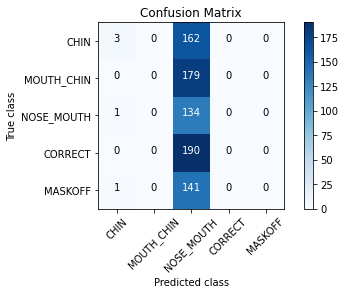

In [12]:
def plot_confusion_matrix(cm, classes_map,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_map))
    inv_map = {v: k for k, v in classes_map.items()}
    labels = inv_map.values()
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis], 2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')


validation_classes = []
validation_images = []

for i in range( -(-validation_generator.samples // validation_generator.batch_size)):
    batch = validation_generator.next()
    expected = np.argmax(batch[1], axis = 1) 
    validation_classes.extend(expected)
    validation_images.extend(batch[0])

validation_classes = np.array(validation_classes)
validation_images = np.array(validation_images)

Y_pred = model.predict(validation_images)
y_pred = np.argmax(Y_pred, axis=1)


print(classification_report(validation_classes, y_pred,
                            target_names = ['CHIN', 'MOUTH_CHIN', 'NOSE_MOUTH', 'CORRECT', 'MASKOFF']))

cfs_mt = confusion_matrix(validation_classes, y_pred)
classes = {'CHIN': 0, 'MOUTH_CHIN': 1, 'NOSE_MOUTH': 2, 'CORRECT': 3, 'MASKOFF': 4}
plot_confusion_matrix(cfs_mt, classes_map = classes)

## Real-time Detection Using OpenCV

In [34]:
config = ConfigProto()
session = InteractiveSession(config=config)


keras_model = tf.keras.models.load_model('/Users/nguyen_l5/Downloads/model_weights_changingDataGen')
#keras_model = load_model('model.h5')
classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')
cam = cv2.VideoCapture(0) 



label = {
    0: {"name": "Mask is not covering nose and mouth", "color": (51, 153, 255), "id": 0},
    1: {"name": "Mash is not covering nose", "color": (255, 255, 0), "id": 1},
    2: {"name": "Mask is not covering chin", "color": (255, 153, 255), "id": 2},
    3: {"name": "Mask is worn correctly", "color": (0, 102, 51), "id": 3},
    4: {"name": "No mask", "color": (0,0,255), "id": 4},
}


while True:
    status, frame = cam.read()

    if not status:
        break

    if cv2.waitKey(1) & 0xff == ord('q'):
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = classifier.detectMultiScale(gray)

    for x,y,w,h in faces:
        color = (0,0,0)
        gray_face = gray[y:y+h+50, x:x+w+50]

        if gray_face.shape[0] >= 200 and gray_face.shape[1] >= 200:

            gray_face = cv2.resize(gray_face, (300, 300))
            gray_face = gray_face / 255
            gray_face = np.expand_dims(gray_face, axis=0)
            gray_face = gray_face.reshape((1, 300, 300, 1))
            pred = np.argmax(keras_model.predict(gray_face))
            classification = label[pred]["name"]
            color = label[pred]["color"]

            cv2.rectangle(frame, (x,y), (x+w, y+h), color, label[pred]["id"])

            cv2.putText(frame, classification, (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
            cv2.putText(frame, f"Number of detected faces: {len(faces)}",(20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2, cv2.LINE_AA)

    
    cv2.imshow("Cam", frame)
    
    #Press Esc to stop the camera
    key = cv2.waitKey(1) & 0xFF
    if key == 27:
        break

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 